### 2.1 Coding Problems
#### 1.Compute SIFT keypoints and corresponding descriptors for images 1Hill and 2Hill
#### 2.Find matching keypoints in two images and display the 20 best pairs.
#### 3.Find homography using RANSAC method and apply transformation to 1Hill. Image 2Hill should not be transformed.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

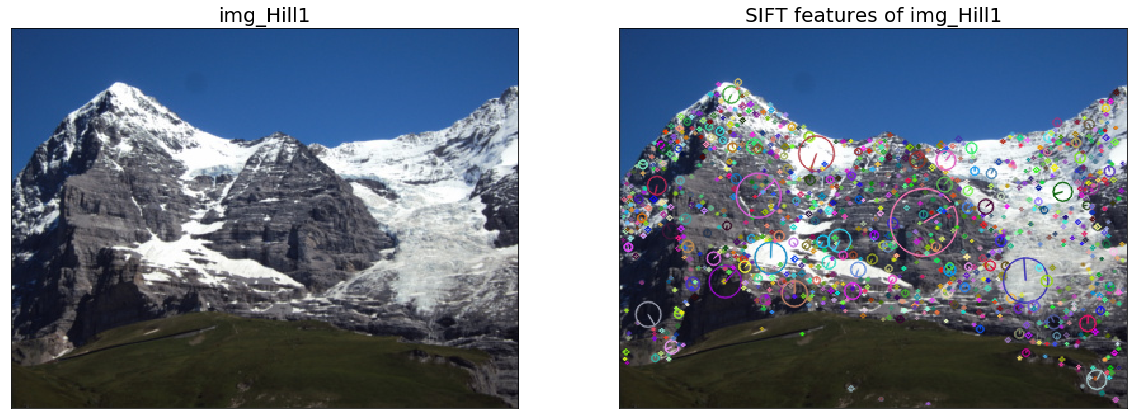

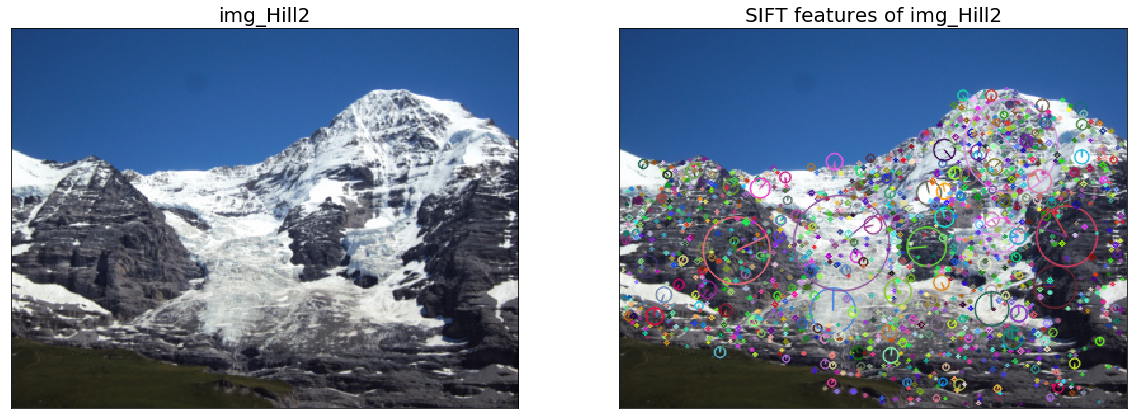

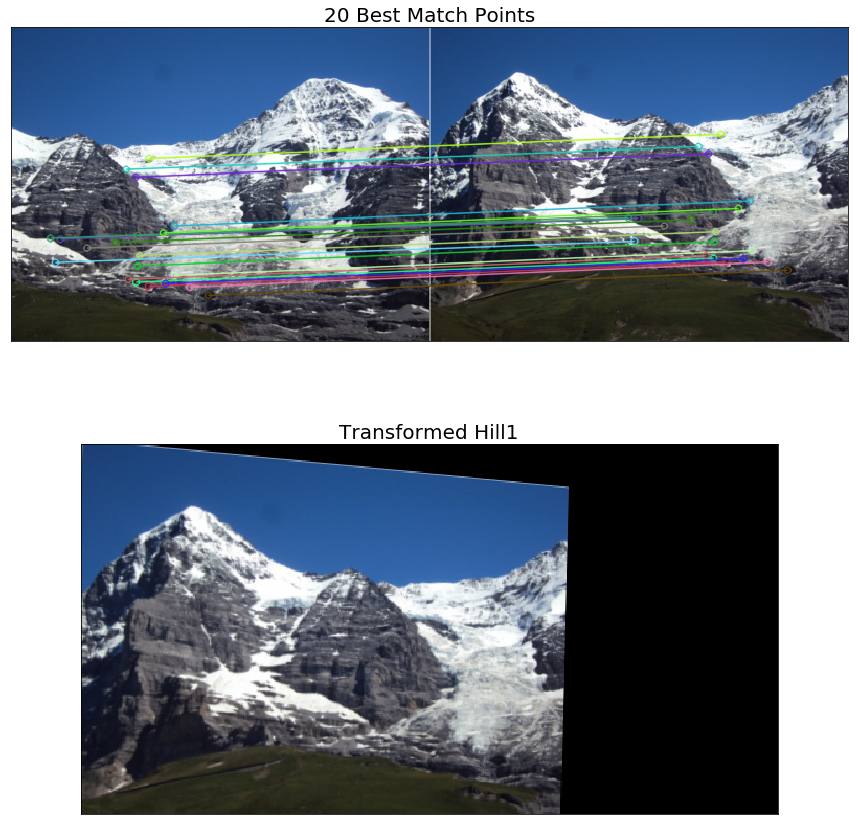

In [2]:
def warpPerspectivePadded(src, dst_shape, M):
    """Performs an affine or Euclidean/rigid warp with padding.
    Parameters
    ----------
    src : image to be warped.
    dst : shape of static image i.e. dst.shape 
    M : `3x3` Homography matrix.
    Returns
    -------
    src_warped : padded and warped source image
    """
    
    # it is enough to find where the corners of the image go to find
    # the padding bounds; points in clockwise order from origin
    _, src_w = src.shape[:2]
    lin_pts = np.array([
        [0, src_w],
        [0, 0]])
    # transform points
    transf_lin_pts = M[:, :2].dot(lin_pts) + M[:, 2].reshape(3, 1)

    # find min and max points
    min_x = np.floor(np.min(transf_lin_pts)).astype(int)
    max_x = np.ceil(np.max(transf_lin_pts)).astype(int)

    # add translation to the transformation matrix to shift to positive values
    anchor_x = 0
    if min_x < 0:
        anchor_x = -min_x
    shifted_transf = M + [[0, 0, anchor_x], [0, 0, 0], [0, 0, 0]]

    # create padded destination image
    dst_h, dst_w,_ = dst_shape
    dst_pad_w = anchor_x + dst_w + max(max_x, dst_w) - dst_w
    src_warped = cv2.warpPerspective(src, shifted_transf, (dst_pad_w, dst_h), borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return src_warped


# load images 
Hill1_path = "./stitching_images/1Hill.JPG"
Hill2_path = "./stitching_images/2Hill.JPG"

img_Hill1 = cv2.imread(Hill1_path)
img_Hill2 = cv2.imread(Hill2_path)

#Convert RGB
img_Hill1 = cv2.cvtColor(img_Hill1, cv2.COLOR_BGR2RGB)
img_Hill2 = cv2.cvtColor(img_Hill2, cv2.COLOR_BGR2RGB)

img_Hill1_copy = img_Hill1.copy()
img_Hill2_copy = img_Hill2.copy()


# create a SIFT object
# for SVRF object, just replace SIFT with SVRF
sift1 = cv2.xfeatures2d.SIFT_create()   

# detect SIFT features, with no masks
keypoints_1, descriptors_1 = sift1.detectAndCompute(img_Hill1, None)
keypoints_2, descriptors_2 = sift1.detectAndCompute(img_Hill2, None)


# create BFMatcher object
bf = cv2.BFMatcher()#cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(descriptors_2,descriptors_1)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Arrange matching keypoints in two separate lists
GoodMatches = []
for i, m in enumerate(matches):
    if m.distance <100:
        GoodMatches.append(m)

# Draw keypoints 
cv2.drawKeypoints(img_Hill1, keypoints_1, img_Hill1_copy, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.drawKeypoints(img_Hill2, keypoints_2, img_Hill2_copy, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Draw match points
imgmatch = cv2.drawMatches(img_Hill2,keypoints_2,img_Hill1,keypoints_1, GoodMatches[:20], img_Hill1, flags=2)

mpr = np.float32([keypoints_2[m.queryIdx].pt for m in GoodMatches])
mp1 = np.float32([keypoints_1[m.trainIdx].pt for m in GoodMatches])

# find homography and wrap image accordingly
H, __ = cv2.findHomography(mp1, mpr, cv2.RANSAC, 4) # have to use RANSAC for one of A2 questions

# apply perspective transform and padding to img_Hill1
wimg = warpPerspectivePadded(img_Hill1,(img_Hill1.shape[0],img_Hill1.shape[1],3),H)

# print the dimensions
plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(img_Hill1)
plt.title("img_Hill1",fontsize = 20), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img_Hill1_copy)
plt.title("SIFT features of img_Hill1",fontsize = 20), plt.xticks([]), plt.yticks([])
plt.show()

plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(img_Hill2)
plt.title("img_Hill2",fontsize = 20), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img_Hill2_copy)
plt.title("SIFT features of img_Hill2",fontsize = 20), plt.xticks([]), plt.yticks([])
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(211), plt.imshow(imgmatch)
plt.title("20 Best Match Points",fontsize = 20), plt.xticks([]), plt.yticks([])
plt.subplot(212), plt.imshow(wimg)
plt.title("Transformed Hill1",fontsize = 20), plt.xticks([]), plt.yticks([])
plt.show()




####  4.Stitch transformed 1Hill and original 2Hill together using pyramid image blending.

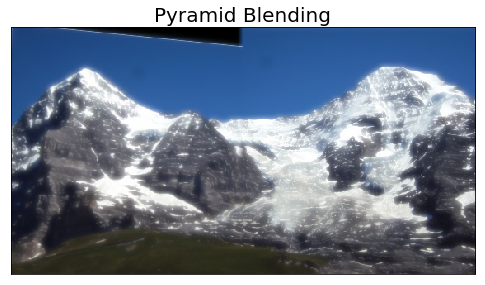

In [3]:
A = wimg.copy()
B = cv2.imread(Hill2_path)

# Use copyMakeBorder function to resize Hill2 and fill the space with black
# copyMakeBorder( src, dst, top, bottom, left, right, borderType, value );
B = cv2.copyMakeBorder(B, 0, 0, (A.shape[1]-B.shape[1]) , 0, cv2.BORDER_CONSTANT,value=0)
A = cv2.cvtColor(A, cv2.COLOR_BGR2RGB)

# parameters
g_size = 255  # gaussian mask blur size
depth = 3  # pyramid depth size


""" PYRAMID BLENDING """
row, col, dpt = A.shape

# generate Image pyramid for imgA
G = A.copy()
gp1 = [G]
for i in range(depth):
    G = cv2.pyrDown(G)
    gp1.append(G)

# generate Image pyramid for imgB
G = B.copy()
gp2 = [G]
for i in range(depth):
    G = cv2.pyrDown(G)
    gp2.append(G)

# generate Laplacian pyramid for imgA
lp1 = [gp1[depth-1]]  # store last gaussian image for top of lp pyramid
for i in range(depth-1,0,-1):
    # upsample lower pyramid
    hr = cv2.pyrUp(gp1[i], dstsize=(gp1[i-1].shape[1], gp1[i-1].shape[0])) #obtain lower reso pyramid
    lp = cv2.subtract(gp1[i-1], hr, cv2.CV_32F)  # subtract different levels
    lp1.append(lp)

# generate Laplacian pyramid for imgB
lp2 = [gp2[depth-1]]  # store last gaussian image for top of lp pyramid
for i in range(depth-1,0,-1):
    # upsample lower pyramid
    hr = cv2.pyrUp(gp2[i], dstsize=(gp2[i-1].shape[1], gp2[i-1].shape[0]))
    lp = cv2.subtract(gp2[i-1], hr, cv2.CV_32F)  # subtract different levels
    lp2.append(lp)

# add left and right halves of images in each level
LP = []
for la, lb in zip(lp1, lp2):
    row, cols, dpt = la.shape
    # stack columns (half and half)
    lp = np.hstack((la[:, :round(cols/2)], lb[:, round(cols/2):]))
    LP.append(lp)
#lp is now a stacked image

    
# build Gaussian pyramid from selected region
mask = np.zeros((A.shape[1], A.shape[0]))

# create mask
mask[:, round(A.shape[1]/2):] = 1

# blur mask
mask = cv2.GaussianBlur(mask, (g_size, g_size), 0)

# generate Gaussian pyramid
G = mask.copy()
GR = [G]
for i in range(depth):
    G = cv2.pyrDown(G)
    GR.append(G)

# add left and right halves of images in each level using Gaussian mask
LP_mask = []
i = 1
for la, lb in zip(lp1, lp2):
    idx = depth - i

    # Now blend
    dim=((1-GR[idx].reshape(GR[idx].shape[1],GR[idx].shape[0],1)) * la)

    dim1=GR[idx].reshape(GR[idx].shape[1],GR[idx].shape[0],1) * lb
   
    lp = (1-GR[idx].reshape(GR[idx].shape[1],GR[idx].shape[0],1)) * la + \
         GR[idx].reshape(GR[idx].shape[1],GR[idx].shape[0],1) * lb
    lp = np.uint8(lp)  # convert back to uint8
    LP_mask.append(lp)
    i += 1

# now reconstruct
rs = LP[0]
for i in range(1, depth):
    rs = cv2.pyrUp(rs)  # upsample current lp image
    rs = cv2.add(rs, LP[i])  # add lp image

# now Gaussian mask reconstruct
rs_mask = LP_mask[0]
for i in range(1, depth):
    rs_mask = cv2.pyrUp(rs_mask)  # upsample current lp image
    rs_mask = cv2.add(rs_mask, LP_mask[i])  # add lp image

# display results
plt.figure(figsize=(10,10))
plt.subplot(211), plt.imshow(cv2.cvtColor(rs, cv2.COLOR_RGB2BGR))
plt.title('Pyramid Blending',fontsize=20), plt.xticks([]), plt.yticks([])
plt.show()



#### 1. Compute SURF keypoints and corresponding descriptors for images 12Hill and 3Hill.
#### 2. Find matching keypoints in two images and display the 20 best pairs.
#### 3. Find homography using RANSAC method and apply transformation to 3Hill. Image 12Hill should not be transformed.



surf execution time: 0.11090421676635742
sift execution time: 0.05808591842651367
Number of SIFT keypoints for Hill3 1393
Number of SURF keypoints for Hill3 876


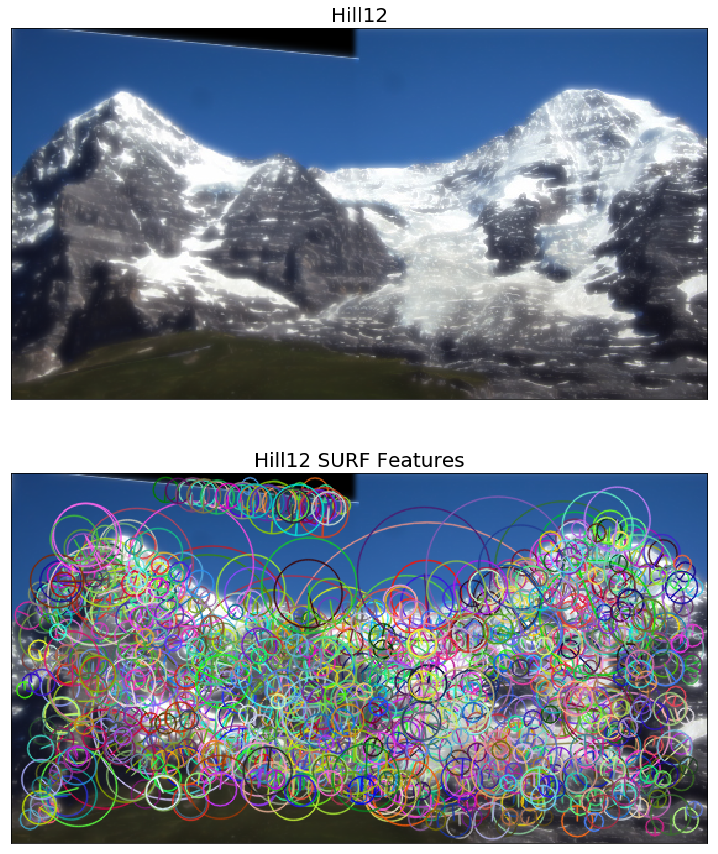

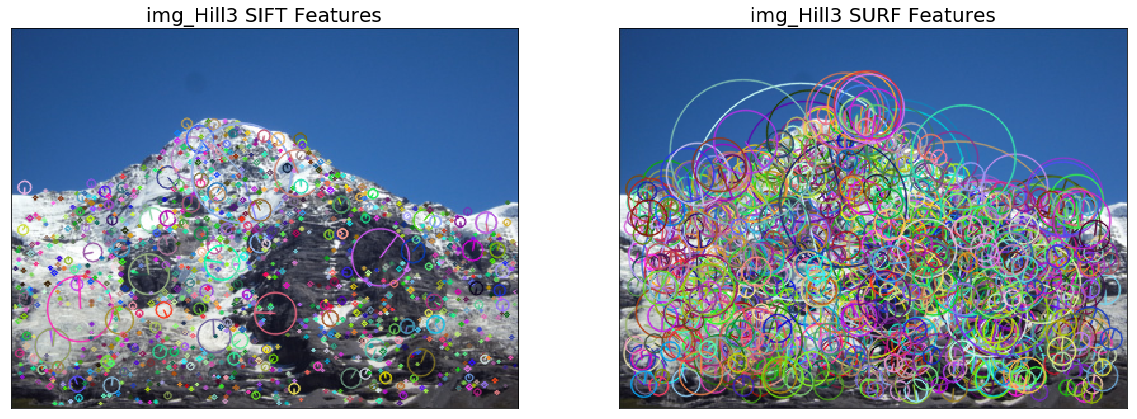

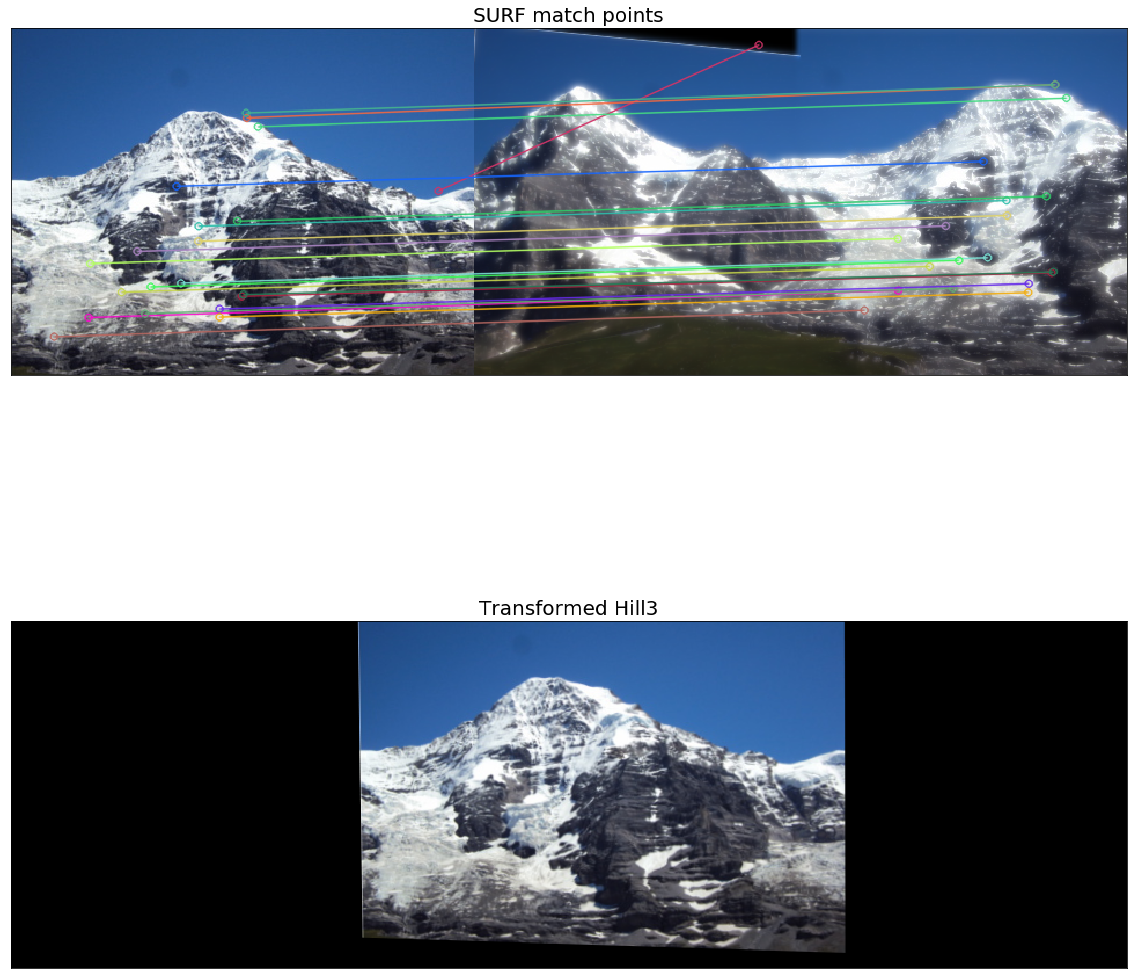

In [4]:
# import the images
Hill3_path = "./stitching_images/3Hill.JPG"
img_Hill3 = cv2.imread(Hill3_path)

# convert BGR to RGB for displaying
img_Hill3 = cv2.cvtColor(img_Hill3, cv2.COLOR_BGR2RGB)
rs_mask = cv2.cvtColor(rs, cv2.COLOR_BGR2RGB)

# make copies of images for displaying SURF keypoints
img_Hill3_copy = img_Hill3.copy()
img_Hill3_copy1 = img_Hill3.copy()
rs_mask_copy = rs_mask.copy()

# create SURF object
surf = cv2.xfeatures2d.SURF_create()
sift_2 = cv2.xfeatures2d.SIFT_create()
# detect SURF features
keypoints_1_surf, descriptors_1_surf = surf.detectAndCompute(rs_mask, None)

t1 = time.time()
keypoints_2_surf, descriptors_2_surf = surf.detectAndCompute(img_Hill3, None)
t2 = time.time()
print("surf execution time:", t2-t1)

t3 = time.time()
keypoints_2_sift, descriptors_2_sift = sift_2.detectAndCompute(img_Hill3, None)
t4 = time.time()
print("sift execution time:", t4-t3)

print("Number of SIFT keypoints for Hill3",len(keypoints_2_sift))
print("Number of SURF keypoints for Hill3",len(keypoints_2_surf))


# draw keypoints
cv2.drawKeypoints(rs_mask, keypoints_1_surf, rs_mask_copy, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.drawKeypoints(img_Hill3, keypoints_2_surf, img_Hill3_copy, flags=4)
cv2.drawKeypoints(img_Hill3, keypoints_2_sift, img_Hill3_copy1, flags=4)


# create BFMatcher object
bf_surf = cv2.BFMatcher()#cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches_surf = bf.match(descriptors_2_surf,descriptors_1_surf)

# Sort them in the order of their distance.
matches_surf = sorted(matches_surf, key = lambda x:x.distance)

# Arrange matching keypoints in two separate lists
GoodMatches_surf = []
for i, m in enumerate(matches_surf):
    if m.distance <100:
        GoodMatches_surf.append(m)


# Draw match points
#imgmatch_surf = cv2.drawMatches(rs_mask,keypoints_1_surf,img_Hill3,keypoints_2_surf, GoodMatches_surf[:20], rs_mask, flags=2)
imgmatch_surf = cv2.drawMatches(img_Hill3,keypoints_2_surf,rs_mask,keypoints_1_surf, GoodMatches_surf[:20], img_Hill3, flags=2)

mpr = np.float32([keypoints_2_surf[m.queryIdx].pt for m in GoodMatches_surf])
mp1 = np.float32([keypoints_1_surf[m.trainIdx].pt for m in GoodMatches_surf])
    
    
# # find homography and wrap image accordingly
H, __ = cv2.findHomography(mpr, mp1, cv2.RANSAC, 4) # have to use RANSAC for one of A2 questions

# apply perspective transform and padding to img_Hill3
wimg_surf = cv2.warpPerspective(img_Hill3, H, (rs_mask.shape[1]+img_Hill3.shape[1],
                                               rs_mask.shape[0]))

# display images
plt.figure(figsize=(15,15))
plt.subplot(211), plt.imshow(rs_mask)
plt.title("Hill12", fontsize=20), plt.xticks([]), plt.yticks([])
plt.subplot(212), plt.imshow(rs_mask_copy)
plt.title("Hill12 SURF Features",fontsize=20), plt.xticks([]), plt.yticks([])
plt.show()

plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(img_Hill3_copy1)
plt.title("img_Hill3 SIFT Features", fontsize=20), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img_Hill3_copy)
plt.title("img_Hill3 SURF Features",fontsize=20), plt.xticks([]), plt.yticks([])
plt.show()

plt.figure(figsize=(20,20))
plt.subplot(211), plt.imshow(imgmatch_surf)
plt.title("SURF match points", fontsize=20), plt.xticks([]), plt.yticks([])
plt.subplot(212), plt.imshow(wimg_surf)
plt.title("Transformed Hill3", fontsize=20), plt.xticks([]), plt.yticks([])
plt.show()


#### 4. Stitch transformed 3Hill and 12Hill together and apply linear image blending.


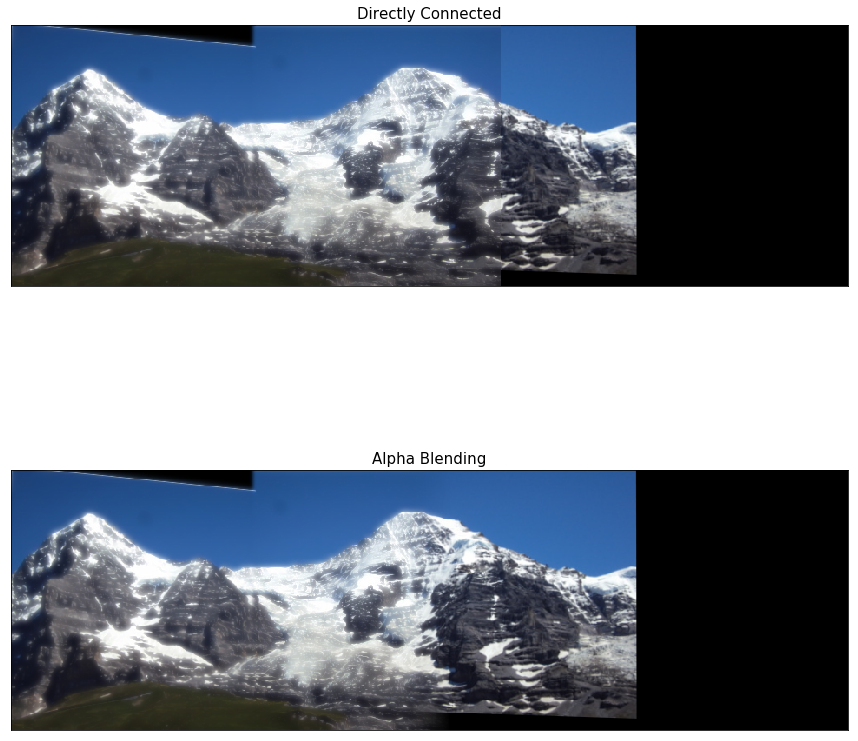

In [5]:
A_surf = rs.copy()
B_surf = wimg_surf.copy()

B_surf = cv2.cvtColor(B_surf, cv2.COLOR_BGR2RGB)

# image with direct connection
real = np.hstack((A_surf[ :,:A_surf.shape[1]], B_surf[:, A_surf.shape[1]:]))


# adjust the size of A
A_surf = cv2.copyMakeBorder(A_surf, 0, 0, 0,(B_surf.shape[1]-A_surf.shape[1]), cv2.BORDER_CONSTANT,value=0)

# width and height of image
col, row = A_surf.shape[0:2]



""" ALPHA BLENDING """
def Ramp(i_width, r_width, r_index, start, end):
    """
    Create alpha blending function
    :param i_width: img width
    :param r_width: ramp width
    :param r_index: center ramp index
    :param start: starting ramp value
    :param end: ending ramp value
    :return:
    """
    a = np.zeros((i_width))
    step = (end - start) / (r_width-1)
    idx = round(r_index - (r_width / 2))  # left side starting index of alpha ramp,539
    for i in range(r_width):
        a[idx] = start + step*i
        idx += 1
    a[idx:] = 1
    return a

# alpha blending ramp
ramp_size = 50  # alpha blending ramp size
alpha = Ramp(B_surf.shape[1], ramp_size, A_surf.shape[1]/2, 0, 1)

# Now blend
I_blend = (1-alpha.reshape(1,-1,1))*A_surf + alpha.reshape(1,-1,1)*B_surf # use this for all mask

I_blend = np.uint8(I_blend)  # convert back to uint8


plt.figure(figsize=(15,15))
plt.subplot(211), plt.imshow(cv2.cvtColor(real, cv2.COLOR_RGB2BGR))
plt.title("Directly Connected", fontsize=15), plt.xticks([]), plt.yticks([])
plt.subplot(212), plt.imshow(cv2.cvtColor(I_blend, cv2.COLOR_RGB2BGR))
plt.title("Alpha Blending", fontsize=15), plt.xticks([]), plt.yticks([])
plt.show()

### 2.2 Reasoning Questions
#### 1. What are the differences between SIFT and SURF? Comment on the speed, number of keypoints and density. Support your arguments with statistics. (4 points)
SURF is about 3-6 times faster than SIFT because SURF eliminates the use of Gaussian pyramids and uses box filters and intergal images to compute keypoints. This can be shown from the execution times calculated in two sections above:
surf execution time: 0.056249141693115234
sift execution time: 0.09518003463745117
SURF generates less keypoints than SIFT and the density of SURF keypoints is also lower than that of SIFT keypoints. This can be shown in the section where the SIFT and SURF keypoints are found for img_Hill3 (2 code cells above). The number of SIFT and SURF keypoints are found to be 1393 and 876 respectively.



#### 2. Discuss at least two pros and cons of pyramid and linear blending techniques. When should one prefer pyramid blending over linear blending?(4 points)
Pyramid blending disadvantages: blended image can lose clarity compared to the original image,
more expensive to implement
Linear blending advantages: faster computation speed, produces clearer blended image





#### 3. What would happen if a random subset of pairs of matching keypoints is used for finding homography? (2 points)
The homography would not be computed correctly since it is dependent on the matching points. If homography is not correct, then the image would not be transformed correctly using the warpPerspective function. As a result, the images would not have a smooth blend.  



#### 4. Discuss the relationship between the number of pairs of matching keypoints used for finding homography and the accuracy of inferred homography. (2 points)
If more pairs of matching keypoints are used to compute homography, the resulting homography would be more accurate because the calculation would take in more consideration of the keypoints.


